## Transfer learning for COVID-19 diagnosis using CT images.

(You need a GPU or AWS account for this task)
You will develop a 2D CNN for COVID-19 diagnosis using CT images.
I will provide you the dataset.
(1) build a CNN based on Resnet-18
(2) train the CNN from scratch
(3) train the CNN using transfer learning
Compare the two models in (2)&(3) to see if transfer learning brings extra benefits or not.

COVID-19 Diagnosis using CT Images

CNN to classify images


## Import Necessary Libraries

In [3]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as tv_models
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(0)

## DataLoaders for CNN

In [4]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import skimage
import skimage.io as io
import pandas as pd

class Dataset(torch_dataset):
    def __init__(self, path, filenameList, labelList):
        self.path=path
        self.filenameList=filenameList
        self.labelList=labelList
    def __len__(self):
        # Length of data
        return len(self.filenameList)
    def __getitem__(self, idx):
        I=io.imread(self.path+self.filenameList[idx])
        I=skimage.util.img_as_float32(I)
        # gray scale CT Image (1)
        I = I.reshape(1,I.shape[0],I.shape[1]) 
        I = torch.tensor(I, dtype=torch.float32)
        # Red Green Blue Image(3)
        I = I.expand(3,I.shape[0],I.shape[1])
        label=torch.tensor(self.labelList[idx], dtype=torch.int64)
        return I, label



## Get Training Data

In [5]:
def getDataloader():
    
    trainCsv = pd.read_csv('/Users/juandollaa/Desktop/ML/hw5t3/S224/train.csv')
    path='/Users/juandollaa/Desktop/ML/hw5t3/S224/'
    trainData = Dataset(path, trainCsv['filename'].values, trainCsv['label'].values)
    print('yes')
    trainLoader = torch_dataloader(trainData, batch_size=32, num_workers=2,
                                    shuffle=True, pin_memory=True)
    return trainLoader


## Get Images

In [30]:
imageEditing = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
trainDataset = datasets.ImageFolder('/Users/juandollaa/Desktop/ML/hw5t3/S224/', transform=imageEditing['train'])
validData = torchvision.datasets.ImageFolder('/Users/juandollaa/Desktop/ML/hw5t3/S224/', transform=imageEditing['val'])
trainLoader = torch_dataloader(trainDataset, batch_size=8, shuffle=True, num_workers=0)
loader_val = torch_dataloader(validData, batch_size=8, shuffle=False, num_workers=0) 

In [31]:
len(trainDataset)

2482

In [32]:
len(trainLoader)

311

In [33]:
len(validData)

2482

In [37]:
len(loader_val)

311

In [38]:
(x,label)=trainDataset[0]
print(x.size())
print(label)

torch.Size([3, 224, 224])
0


In [39]:
(x,label)=trainDataset[200]
print(x.size())
print(label)

torch.Size([3, 224, 224])
0


## Image Getter

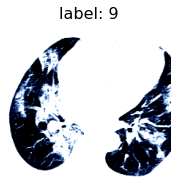

In [40]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 10, 1):
    x = trainDataset[n][0].detach().cpu().numpy()
    y = trainDataset[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(n), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)  

## Resnet18 CNN

In [41]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        self.resnet18 = tv_models.resnet18(pretrained=True)
        #binary classification  
        self.resnet18.fc=torch.nn.Linear(512, 1)           
        #freeze all parameters
        for p in self.resnet18.parameters():
            p.requires_grad = False 
        #layer4 to be trainable       
        for p in self.resnet18.layer4.parameters():
            p.requires_grad = True       
        #fc to be trainable       
        for p in self.resnet18.fc.parameters():
            p.requires_grad = True       
        
    def parametersList(self):
        pList=list(self.resnet18.layer4.parameters())+list(self.resnet18.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet18(x)
        z = z.view(-1)
        return z

In [42]:
def checkPoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [43]:
resnet18 = tv_models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model in one epoch

In [44]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        print(X.shape, Y.shape)
        print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Z = model(X)
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        loss.backward()
        optimizer.step()
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

## Test the Model

In [45]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

## Model, Train, Validation

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
optimizer = optim.SGD(model.parametersList(), lr=0.0001, momentum=0.99) 

(x,label)=trainDataset[0]
x=x.view(1,3,224,224).to(device)
z=model(x)



In [ ]:
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

In [47]:
z

tensor([-0.3136], grad_fn=<ViewBackward>)

In [48]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.4222], grad_fn=<SigmoidBackward>)

In [49]:
z.size()

torch.Size([1])

In [50]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

## Update learning rate

In [51]:
lr_new=0.0001
for g in optimizer.param_groups:
    g['lr']=lr_new

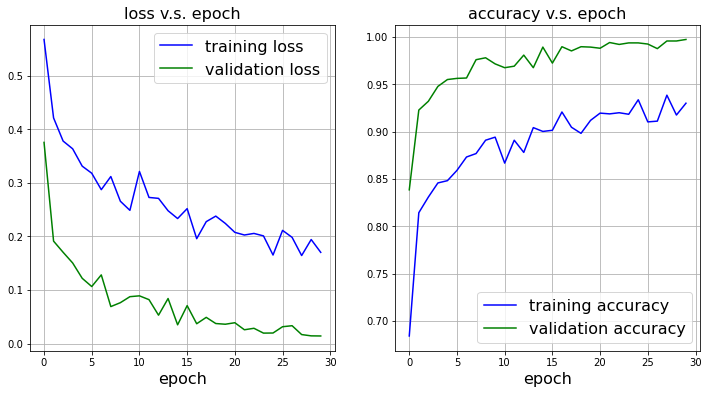

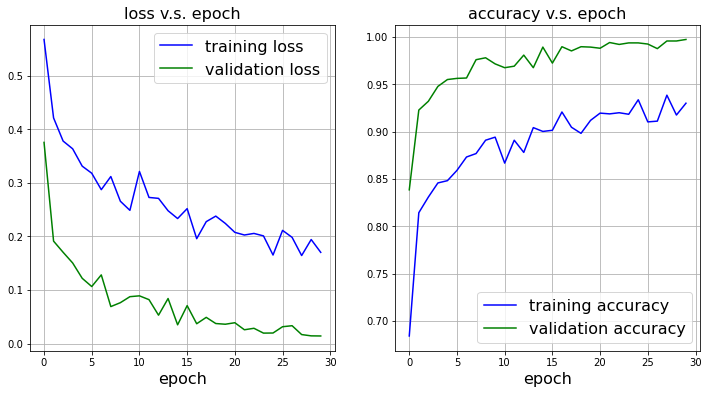

In [52]:
for epoch in range(epoch_save+1, 20):
    # Train
    loss_train, acc_train =train(model, device, optimizer, trainLoader, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    # Validation 
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    # Save model
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    checkPoint('CNN_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    # Show result 
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

## Load the best model

In [53]:
best_id= np.array(acc_val_list).argmax()
best_id

29

In [54]:
epoch_save=19
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('CNN_epoch'+str(epoch_save)+'.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 

optimizer = optim.SGD(model.parametersList(), lr=0.0001, momentum=0.99) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']   

In [55]:
loss_val, acc_val, (Confusion, Acc, Sens, Prec) = test(model, device, loader_val)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('Accuracy (average)', acc_val)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)


Accuracy (average) 0.9971796937953263
Accuracy (average) 0.9971796937953263
Sensitivity [0.99680511 0.99756098]
Precision [0.99760192 0.99675061]


## First Convolution Layer

In [56]:
w=model.resnet18.conv1.weight
w.size()

torch.Size([64, 3, 7, 7])

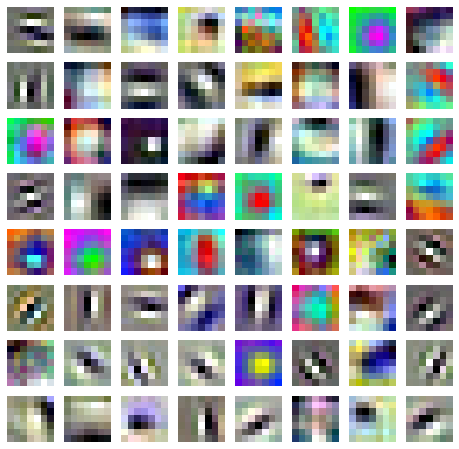

In [57]:
w=model.resnet18.conv1.weight.detach().cpu().numpy()
fig, ax = plt.subplots(8,8, figsize=(8,8))
for i, axi in enumerate(ax.flat):
    I = w[i,:,:,:]
    I = I.transpose(1,2,0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    axi.imshow(I)
    axi.axis('off')

## Input vs Gradient Loss

In [58]:
def normalizeImage(I):
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)    
    I = (I - I_min)/(I_max-I_min)
    return I

Text(0.5, 1.0, 'abs(dL/dx)')

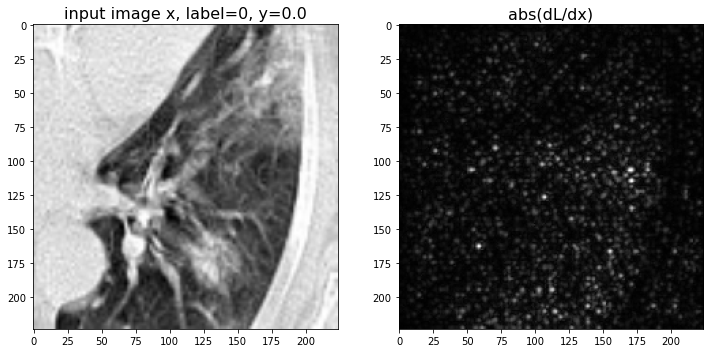

In [59]:
(x,label)=trainDataset[10]
x=x.view(1,3,224,224).to(device)
x.requires_grad=True
z=model(x)
y=torch.tensor([label], dtype=x.dtype, device=device)
loss = nnF.binary_cross_entropy_with_logits(z, y)
loss.backward()

y=y.item()
xx = x.detach().cpu().numpy().squeeze()
xx=xx.transpose(1,2,0)
x_grad=x.grad.data.detach().cpu().numpy().squeeze()
x_grad=x_grad.transpose(1,2,0)
x_grad=np.abs(x_grad).sum(axis=2)
xx = normalizeImage(xx)

fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(xx)
ax[0].set_title('input image x, label='+str(label)+', y='+str(y), fontsize=16)
ax[1].imshow(x_grad, cmap='gray', vmin=x_grad.min(), vmax=x_grad.max())
ax[1].set_title('abs(dL/dx)', fontsize=16)

(-0.5, 223.5, 223.5, -0.5)

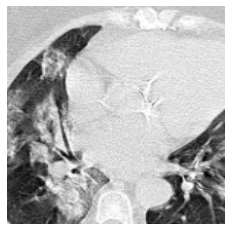

In [60]:
(x,label)=trainDataset[10]
x = x.detach().cpu().numpy().squeeze().transpose(1,2,0)
x = normalizeImage(x)
fig, ax = plt.subplots()
ax.imshow(x)
ax.axis('off')